In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [4]:
# for making plots:
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}

In [11]:
# reference:
ref_annot = pd.read_csv('../data/raw/ref_annot.csv')

In [12]:
REGION_SIZE = 50

In [13]:
WINDOW_SIZE = 10

In [14]:
def histogram_intersection(hist1: np.ndarray, hist2: np.ndarray):
    return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)

In [15]:
def df_intersection(lst_of_ndarray, df_sort_by_G4_id):
    lst = []
    for i in range(len(lst_of_ndarray)):
        
        j = 0

        while j < len(lst_of_ndarray):
            row = []
            if len(lst_of_ndarray[i]) > len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[j])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i][:length], lst_of_ndarray[j]))
                lst.append(row)
            elif len(lst_of_ndarray[i]) < len(lst_of_ndarray[j]):
                length = len(lst_of_ndarray[i])

                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j][:length]))
                lst.append(row)
            else:
                row.append(i)
                row.append(j)
                row.append(histogram_intersection(lst_of_ndarray[i], lst_of_ndarray[j]))
            
                lst.append(row)
            j += 1
    
    df = pd.DataFrame(lst, columns=['G4_id_1', 'G4_id_2', 'intersection'])
    df['G4_id_1'] = np.repeat(df_sort_by_G4_id['G4_id'].unique(), len(lst_of_ndarray)).tolist()
    df['G4_id_2'] = df_sort_by_G4_id['G4_id'].unique().tolist()*len(lst_of_ndarray)
    
    return df

In [16]:
def get_intersection_df(df, up_side=True, i_col=None):
    if up_side==True:
        df_sort_up = df[(df['side'] == 'up')][['G4_id', 'number_of_win', i_col]] \
            .sort_values(by=['G4_id','number_of_win'])
    
        bins_up = []
        for G4_id in df_sort_up['G4_id'].unique():
            bins_up.append(df_sort_up[(df_sort_up['G4_id'] == G4_id)][i_col].values)

        df_out = df_intersection(bins_up, df_sort_up)
    
    else:
        df_sort_down = df[(df['side'] == 'down')][['G4_id', 'number_of_win', i_col]] \
            .sort_values(by=['G4_id','number_of_win'])

        bins_down = []
        for G4_id in df_sort_down['G4_id'].unique():
            bins_down.append(df_sort_down[(df_sort_down['G4_id'] == G4_id)][i_col].values)

        df_out = df_intersection(bins_down, df_sort_down)
    
    return df_out


def plot_intersecton(df: pd.DataFrame, title=None):
    output_plot = sns.clustermap(df.pivot(index='G4_id_1', columns='G4_id_2', values='intersection'), figsize=(12, 12),
           xticklabels=True, yticklabels=True).fig.suptitle(title)

    

In [17]:
def get_norm_mutspec(df):
    
    normMut = pd.DataFrame()
    
    normMut[['A>C','A>G','A>T']] = df[['A>C','A>G','A>T']].div(df['A'], axis=0)
    normMut[['C>A','C>G','C>T']] = df[['C>A','C>G','C>T']].div(df['C'], axis=0)
    normMut[['G>A', 'G>C', 'G>T']] = df[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
    normMut[['T>A', 'T>C', 'T>G']] = df[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)
    
    normMut = normMut.fillna(0)
    normMut = normMut.div(normMut.sum(axis=1), axis=0)
    
    normMut.columns = normMut.columns.str.translate(complementator)
    
    return normMut

# Cancer win analysis

In [19]:
df_win_cancer = pd.read_csv('../data/processed/df_win_cancer.csv')

[Text(0.5, 1.0, 'Number of mutation around G4')]

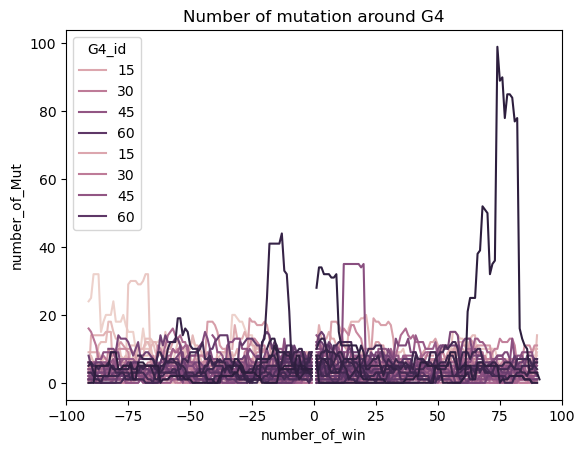

In [20]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='up'], x=-df_win_cancer['number_of_win'], y='number_of_Mut', hue='G4_id')
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='down'], x='number_of_win', y='number_of_Mut', hue='G4_id')\
    .set(title='Number of mutation around G4')

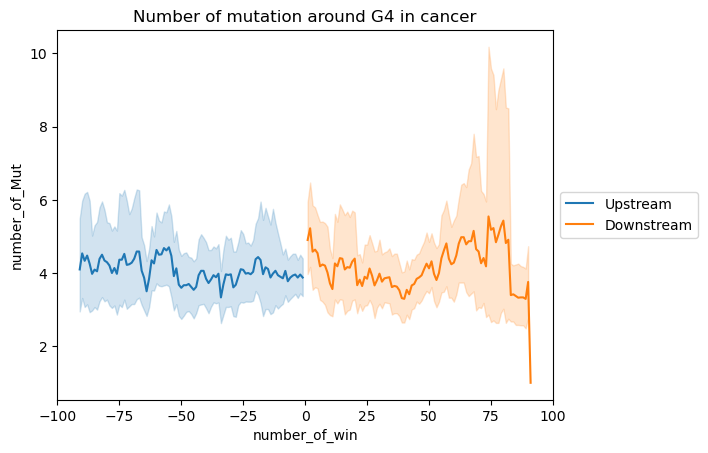

In [21]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='up'],
             x=-df_win_cancer['number_of_win'], y='number_of_Mut', label='Upstream')
sns.lineplot(data=df_win_cancer[(df_win_cancer['side']=='down')], 
             x='number_of_win', y='number_of_Mut', label='Downstream')
axs.set(title='Number of mutation around G4 in cancer')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

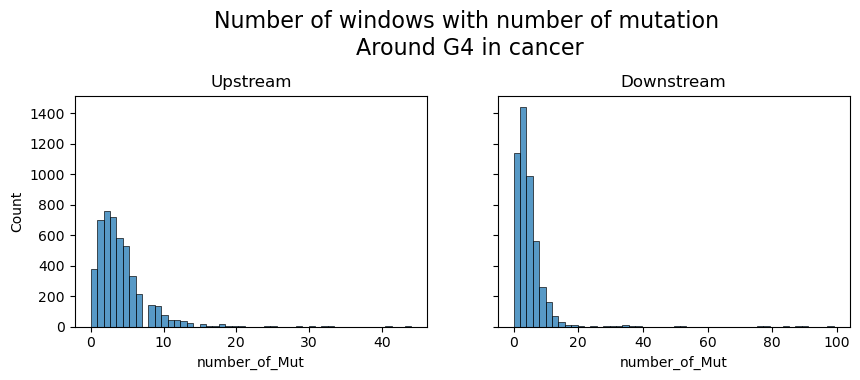

In [22]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
sns.histplot(df_win_cancer[df_win_cancer['side'] == 'up']['number_of_Mut'], ax=axs[0], bins=50).set(title='Upstream')
sns.histplot(df_win_cancer[df_win_cancer['side'] == 'down']['number_of_Mut'], ax=axs[1], bins=50).set(title='Downstream')

fig.suptitle(x=0.52, y=1, t='Number of windows with number of mutation \nAround G4 in cancer', fontsize=16, ha='center', va='bottom')

fig.subplots_adjust(top=0.88)

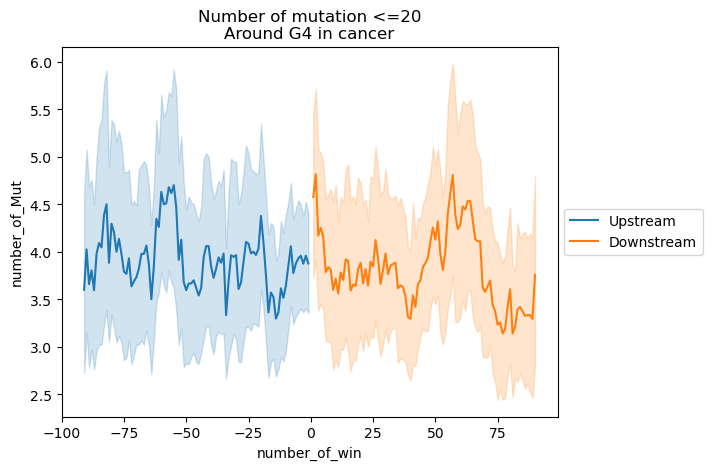

In [23]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[(df_win_cancer['side']=='up') & (df_win_cancer['number_of_Mut'] <= 20)],
             x=-df_win_cancer['number_of_win'], y='number_of_Mut', label='Upstream')
sns.lineplot(data=df_win_cancer[(df_win_cancer['side']=='down') & (df_win_cancer['number_of_Mut'] <= 20) & (df_win_cancer['number_of_win'] < 91)], 
             x='number_of_win', y='number_of_Mut', label='Downstream')
axs.set(title='Number of mutation <=20\nAround G4 in cancer')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [24]:
df_win_cancer[df_win_cancer['side']=='up']['number_of_Mut'].mean()

4.050500834724541

In [25]:
df_win_cancer[df_win_cancer['side']=='down']['number_of_Mut'].mean()

4.181779661016949

## Compare upstream and downstream windows separately

In [26]:
df_i_up = get_intersection_df(df_win_cancer, up_side=True, i_col='number_of_Mut')
df_i_down = get_intersection_df(df_win_cancer, up_side=False, i_col='number_of_Mut')

C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)
C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


[Text(0.5, 1.0, 'Downstream')]

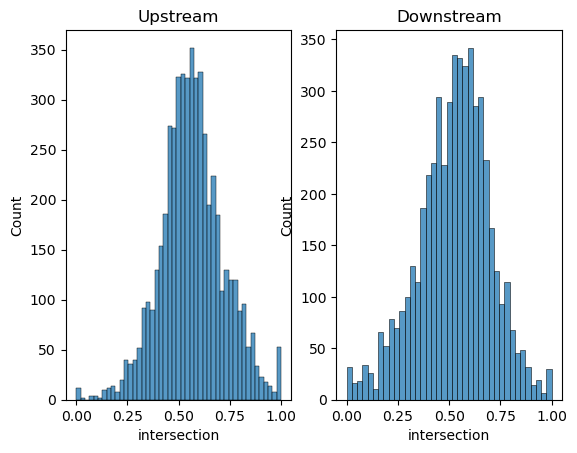

In [27]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(df_i_up['intersection'], ax=axs[0]).set(title='Upstream')
sns.histplot(df_i_down['intersection'], ax=axs[1]).set(title='Downstream')

C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


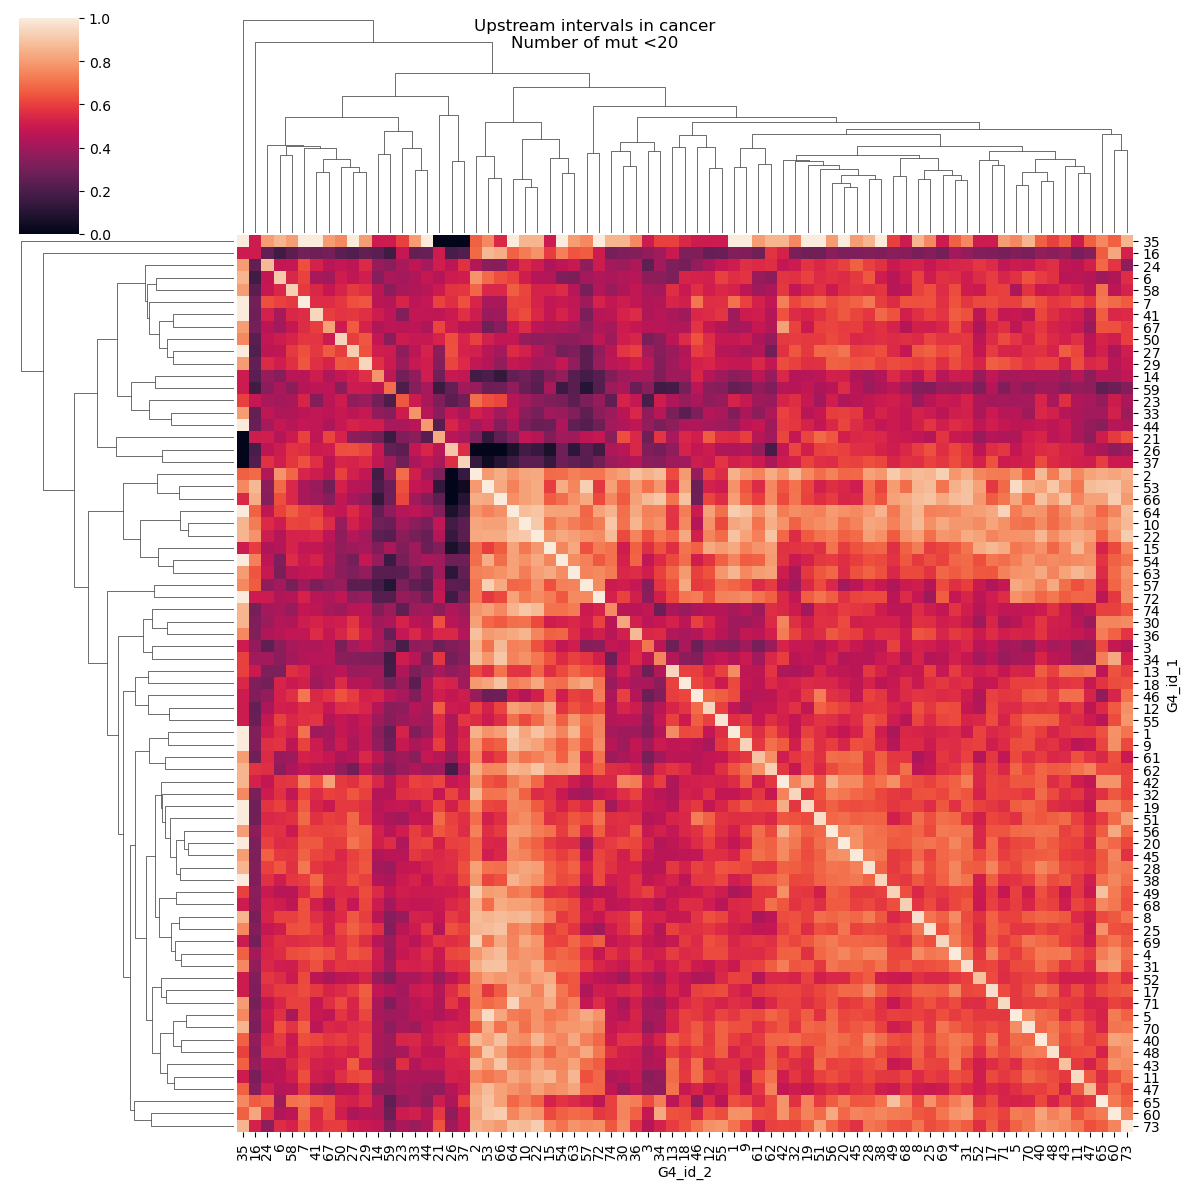

In [28]:
plot_intersecton(get_intersection_df(df_win_cancer[(df_win_cancer['number_of_Mut'] <= 20)], up_side=True, i_col='number_of_Mut'),  
                 title='Upstream intervals in cancer\nNumber of mut <20')

C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


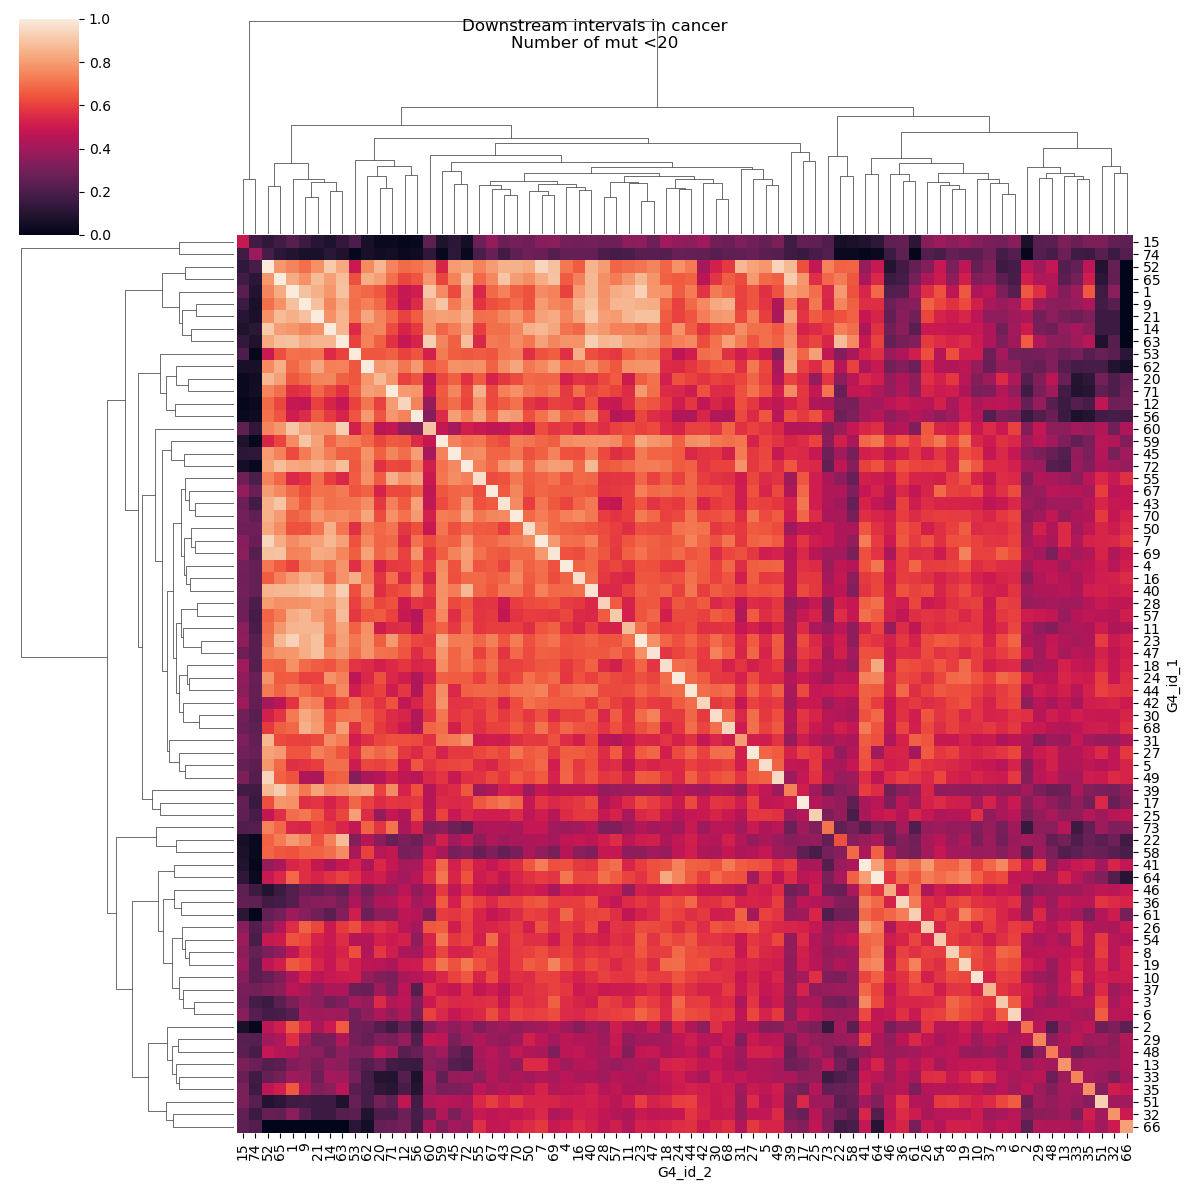

In [29]:
plot_intersecton(get_intersection_df(df_win_cancer[(df_win_cancer['number_of_Mut'] <= 20)], up_side=False, i_col='number_of_Mut'),  
                 title='Downstream intervals in cancer\nNumber of mut <20')

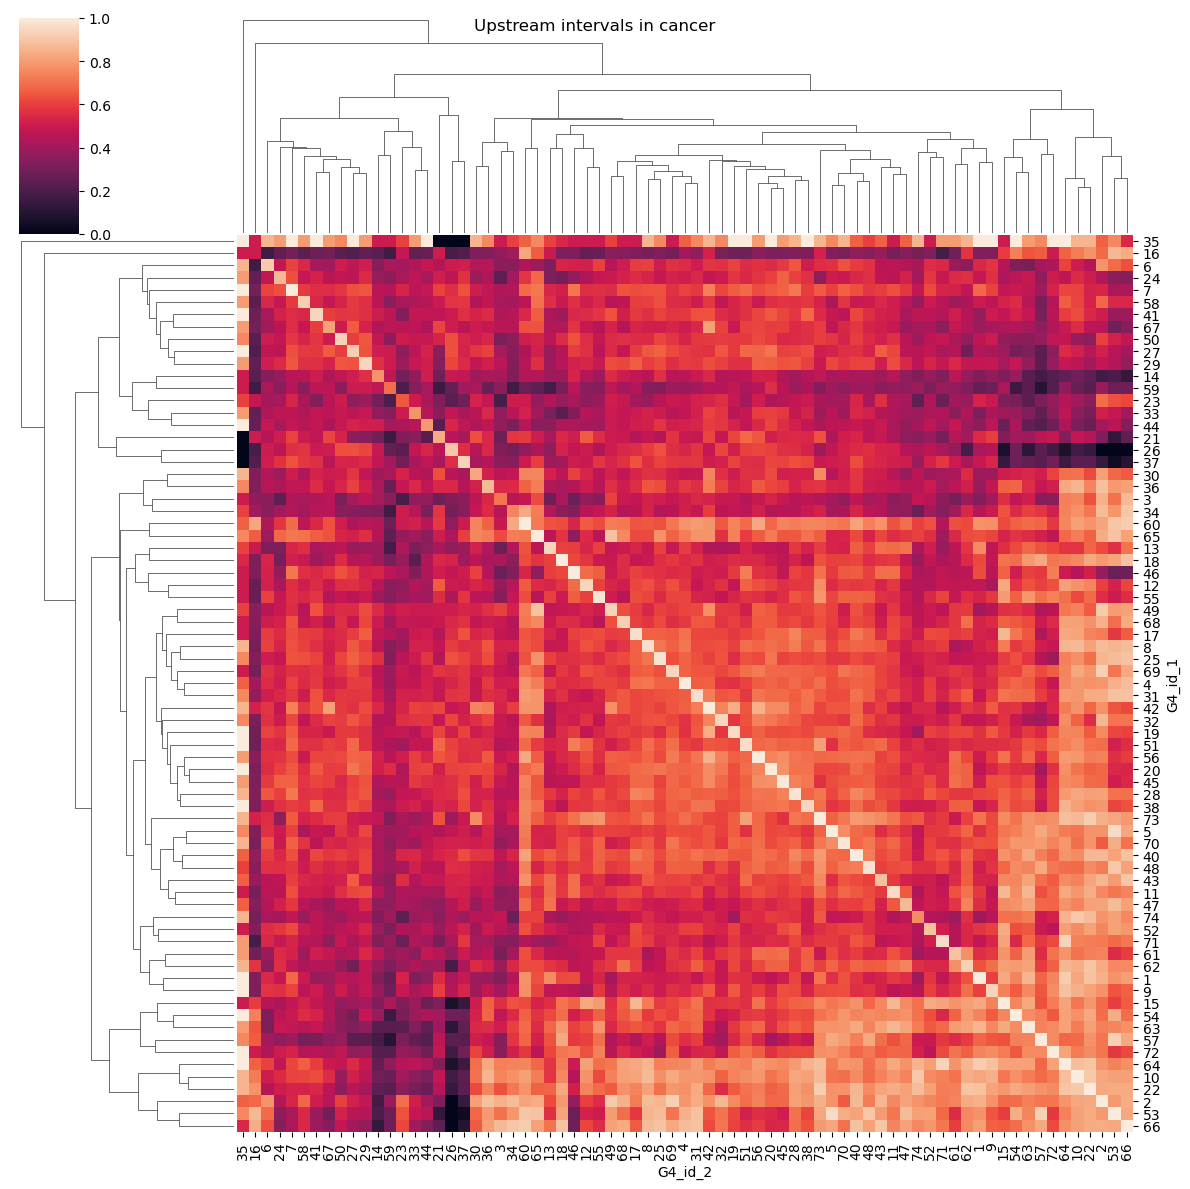

In [30]:
plot_intersecton(df_i_up, title='Upstream intervals in cancer')

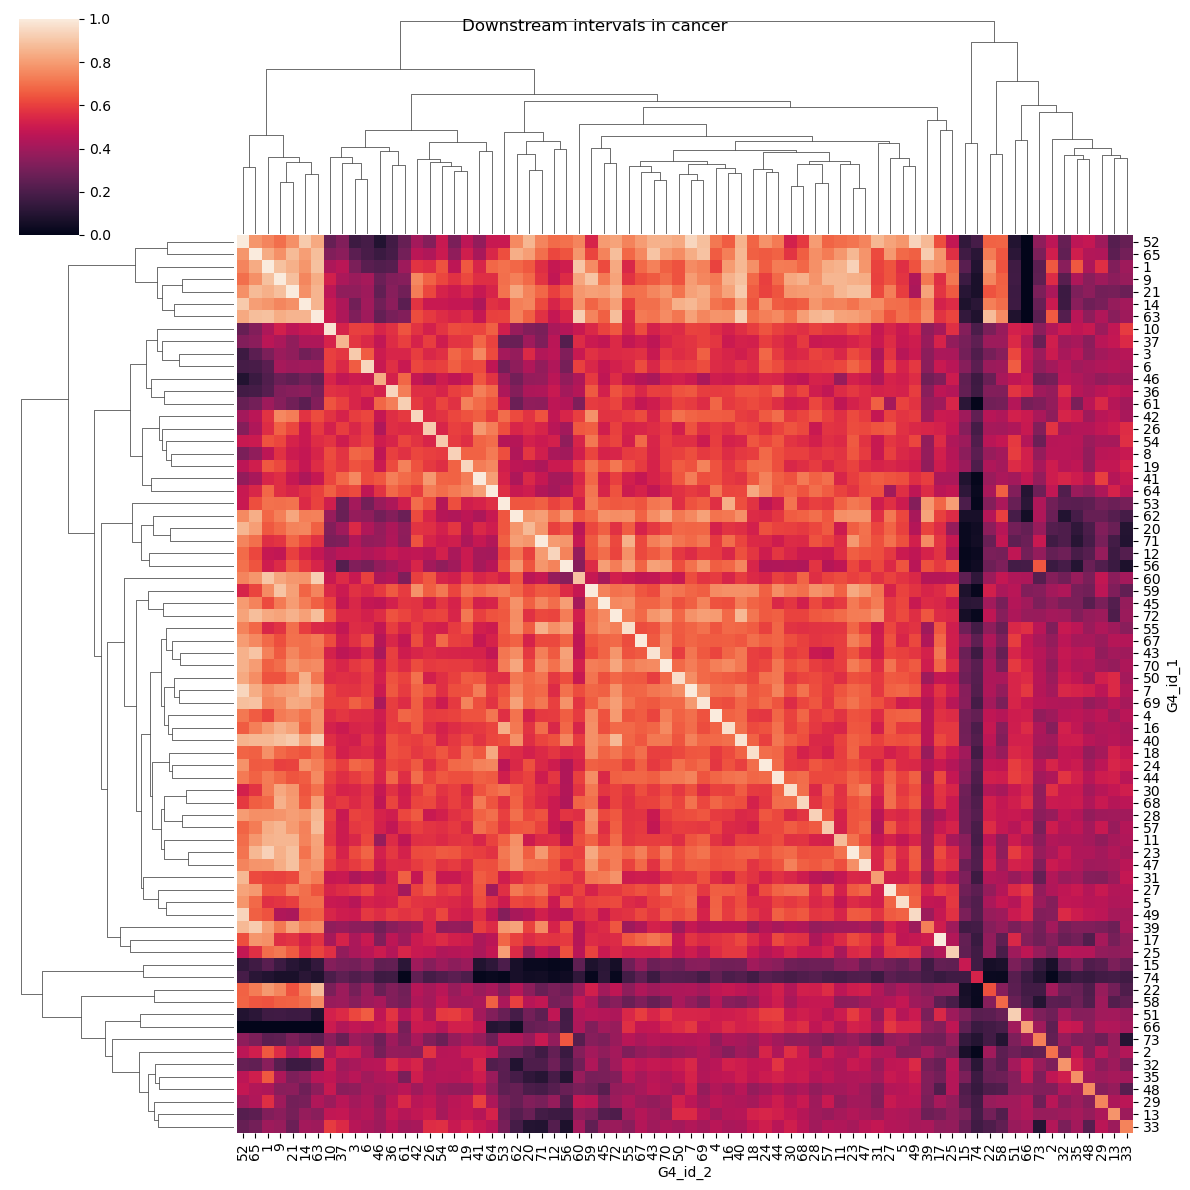

In [31]:
plot_intersecton(df_i_down, title='Downstream intervals in cancer')

In [32]:
outgroup_up = [35, 16, 14, 59, 23, 33, 44, 21, 26, 37]
outgroup_down = [15, 74, 39, 17, 25, 73, 22, 58, 2, 29, 48, 13, 33, 35, 51, 32, 66]

### We have outgroups: ???  
- Upstream: 35, 16; 14, 59, 23, 33, 44, 21, 26, 37  
- Downstream: 15, 74; 22, 58, 51, 66, 73, 2, 32, 35, 48, 29, 13, 33

In [34]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [35]:
# upstream
g4conf[(g4conf['G4_id'].isin(outgroup_up)) & (g4conf['bp_untill_previous_G4'] >= 100)]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
13,"NC_012920.1 Homo sapiens mitochondrion, comple...",4086,4111,26,-,-1.080,-1.08,1,25,CACCAAGACCCTACTTCTAACCTCCC,...,NaN,3986,4211,4036,4161,19,102,14,3986,4130
25,"NC_012920.1 Homo sapiens mitochondrion, comple...",6410,6464,55,-,-1.050,-1.44,1,25,CAATATAAAACCCCCTGCCATAACCCAATACCAAACGCCCCTCTTC...,...,more than africa,6310,6564,6360,6514,81,168,26,6310,6545
32,"NC_012920.1 Homo sapiens mitochondrion, comple...",8455,8488,34,-,-1.090,-1.36,1,25,CACAAACTACCACCTACCTCCCTCACCAAAGCCC,...,NaN,8355,8588,8405,8538,56,150,33,8355,8544
36,"NC_012920.1 Homo sapiens mitochondrion, comple...",8917,8958,42,-,-0.881,-1.56,1,25,CAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATC,...,more than africa,8817,9058,8867,9008,285,102,37,8817,9058
43,"NC_012920.1 Homo sapiens mitochondrion, comple...",10912,10990,79,-,-1.330,-2.08,1,25,CTGTTCCCCAACCTTTTCCTCCGACCCCCTAACAACCCCCCTCCTA...,...,2 g4 in africa,10812,11090,10862,11040,132,275,44,10812,11090


In [36]:
# downstream
g4conf[(g4conf['G4_id'].isin(outgroup_down)) & (g4conf['bp_untill_next_G4'] >= 100)]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
12,"NC_012920.1 Homo sapiens mitochondrion, comple...",3951,3984,34,-,-0.882,-1.20,1,25,CGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCC,...,more than africa,3851,4084,3901,4034,102,42,13,3909,4084
24,"NC_012920.1 Homo sapiens mitochondrion, comple...",6213,6242,30,-,-0.900,-1.04,1,25,CTCTTACCTCCCTCTCTCCTACTCCTGCTC,...,2 overlapping g4 in africa,6113,6342,6163,6292,168,297,25,6113,6342
28,"NC_012920.1 Homo sapiens mitochondrion, comple...",7386,7427,42,-,-1.020,-1.56,1,25,CTATATGGATGCCCCCCACCCTACCACACATTCGAAGAACCC,...,more than africa,7286,7527,7336,7477,371,535,29,7286,7527
31,"NC_012920.1 Homo sapiens mitochondrion, comple...",8252,8305,54,-,-1.220,-2.00,1,25,CCCGTATTTACCCTATAGCACCCCCTCTACCCCCTCTAGAGCCCAC...,...,more than africa,8152,8405,8202,8355,150,278,32,8152,8405
34,"NC_012920.1 Homo sapiens mitochondrion, comple...",8595,8643,49,-,-1.020,-1.76,1,25,CATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAAC,...,more than africa,8495,8743,8545,8693,148,10,35,8585,8743
38,"NC_012920.1 Homo sapiens mitochondrion, comple...",9268,9293,26,-,-1.150,-1.12,1,25,CCCTCTCAGCCCTCCTAATGACCTCC,...,NaN,9168,9393,9218,9343,212,6,39,9262,9393
47,"NC_012920.1 Homo sapiens mitochondrion, comple...",11655,11692,38,-,-0.816,-1.20,1,25,CAGCCATTCTCATCCAAACCCCCTGAAGCTTCACCGGC,...,more than africa,11555,11792,11605,11742,371,100,48,11555,11792
50,"NC_012920.1 Homo sapiens mitochondrion, comple...",12542,12573,32,-,-1.060,-1.20,1,25,CCACAACCCAAACAACCCAGCTCTCCCTAAGC,...,more than africa,12442,12673,12492,12623,378,92,51,12450,12673
72,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,...,more than africa,16244,16482,16294,16432,145,43,73,16301,16482
73,"NC_012920.1 Homo sapiens mitochondrion, comple...",16527,16560,34,-,-0.853,-1.16,1,25,CCTAAATAGCCCACACGTTCCCCTTAAATAAGAC,...,more than africa,16427,91,16477,16610,294,145,74,16427,16660


In [37]:
g4conf[(g4conf['G4_id'].isin(outgroup_up))]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
13,"NC_012920.1 Homo sapiens mitochondrion, comple...",4086,4111,26,-,-1.080,-1.08,1,25,CACCAAGACCCTACTTCTAACCTCCC,...,NaN,3986,4211,4036,4161,19,102,14,3986,4130
15,"NC_012920.1 Homo sapiens mitochondrion, comple...",4228,4260,33,-,-1.210,-1.28,1,25,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,...,NaN,4128,4360,4178,4310,112,67,16,4161,4360
20,"NC_012920.1 Homo sapiens mitochondrion, comple...",5288,5342,55,-,-0.982,-1.40,1,25,CAATAGCCTCATCATCCCCACCATCATAGCCACCATCACCCTCCTT...,...,NaN,5188,5442,5238,5392,21,33,21,5255,5363
22,"NC_012920.1 Homo sapiens mitochondrion, comple...",5424,5499,76,-,-1.200,-1.92,1,25,CATACAAAACCCACCCCATTCCTCCCCACACTCATCGCCCTTACCA...,...,2 g4 in africa,5324,5599,5374,5549,376,32,23,5392,5599
25,"NC_012920.1 Homo sapiens mitochondrion, comple...",6410,6464,55,-,-1.050,-1.44,1,25,CAATATAAAACCCCCTGCCATAACCCAATACCAAACGCCCCTCTTC...,...,more than africa,6310,6564,6360,6514,81,168,26,6310,6545
32,"NC_012920.1 Homo sapiens mitochondrion, comple...",8455,8488,34,-,-1.090,-1.36,1,25,CACAAACTACCACCTACCTCCCTCACCAAAGCCC,...,NaN,8355,8588,8405,8538,56,150,33,8355,8544
34,"NC_012920.1 Homo sapiens mitochondrion, comple...",8595,8643,49,-,-1.020,-1.76,1,25,CATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAAC,...,more than africa,8495,8743,8545,8693,148,10,35,8585,8743
36,"NC_012920.1 Homo sapiens mitochondrion, comple...",8917,8958,42,-,-0.881,-1.56,1,25,CAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATC,...,more than africa,8817,9058,8867,9008,285,102,37,8817,9058
43,"NC_012920.1 Homo sapiens mitochondrion, comple...",10912,10990,79,-,-1.330,-2.08,1,25,CTGTTCCCCAACCTTTTCCTCCGACCCCCTAACAACCCCCCTCCTA...,...,2 g4 in africa,10812,11090,10862,11040,132,275,44,10812,11090
58,"NC_012920.1 Homo sapiens mitochondrion, comple...",14049,14074,26,-,-1.120,-1.12,1,25,CTCCACCTCCATCATCACCTCAACCC,...,NaN,13949,14174,13999,14124,35,45,59,14004,14109


In [38]:
g4conf[(g4conf['G4_id'].isin(outgroup_down))]

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
12,"NC_012920.1 Homo sapiens mitochondrion, comple...",3951,3984,34,-,-0.882,-1.20,1,25,CGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCC,...,more than africa,3851,4084,3901,4034,102,42,13,3909,4084
14,"NC_012920.1 Homo sapiens mitochondrion, comple...",4130,4161,32,-,-0.938,-1.16,1,25,CAGCATACCCCCGATTCCGCTACGACCAACTC,...,NaN,4030,4261,4080,4211,67,19,15,4111,4228
16,"NC_012920.1 Homo sapiens mitochondrion, comple...",4372,4398,27,-,-1.220,-1.28,1,25,CTCCGTGCCACCTATCACACCCCATCC,...,NaN,4272,4498,4322,4448,58,112,17,4272,4456
21,"NC_012920.1 Homo sapiens mitochondrion, comple...",5363,5392,30,-,-1.030,-1.20,1,25,CTCCACCTCAATCACACTACTCCCCATATC,...,NaN,5263,5492,5313,5442,32,21,22,5342,5424
24,"NC_012920.1 Homo sapiens mitochondrion, comple...",6213,6242,30,-,-0.900,-1.04,1,25,CTCTTACCTCCCTCTCTCCTACTCCTGCTC,...,2 overlapping g4 in africa,6113,6342,6163,6292,168,297,25,6113,6342
28,"NC_012920.1 Homo sapiens mitochondrion, comple...",7386,7427,42,-,-1.020,-1.56,1,25,CTATATGGATGCCCCCCACCCTACCACACATTCGAAGAACCC,...,more than africa,7286,7527,7336,7477,371,535,29,7286,7527
31,"NC_012920.1 Homo sapiens mitochondrion, comple...",8252,8305,54,-,-1.220,-2.00,1,25,CCCGTATTTACCCTATAGCACCCCCTCTACCCCCTCTAGAGCCCAC...,...,more than africa,8152,8405,8202,8355,150,278,32,8152,8405
32,"NC_012920.1 Homo sapiens mitochondrion, comple...",8455,8488,34,-,-1.090,-1.36,1,25,CACAAACTACCACCTACCTCCCTCACCAAAGCCC,...,NaN,8355,8588,8405,8538,56,150,33,8355,8544
34,"NC_012920.1 Homo sapiens mitochondrion, comple...",8595,8643,49,-,-1.020,-1.76,1,25,CATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAAC,...,more than africa,8495,8743,8545,8693,148,10,35,8585,8743


In [39]:
print('Outgroup G4 up\n\n', df_win_cancer[(df_win_cancer['G4_id'].isin(outgroup_up)) & (df_win_cancer['side'] == 'up')]
      .groupby(['G4_id'])
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})
      .median())

Outgroup G4 up

 number_of_win    74.5
number_of_Mut     2.5
dtype: float64


In [40]:
print('Other up G4\n\n', df_win_cancer[~(df_win_cancer['G4_id'].isin(outgroup_up)) & (df_win_cancer['side'] == 'up')]
      .groupby(['G4_id'])
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})
      .median())

Other up G4

 number_of_win    91.0
number_of_Mut     4.0
dtype: float64


In [41]:
print('Outgroup G4 down\n\n', df_win_cancer[(df_win_cancer['G4_id'].isin(outgroup_down)) & (df_win_cancer['side'] == 'down')]
      .groupby(['G4_id'])
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})
      .median())

Outgroup G4 down

 number_of_win    90.0
number_of_Mut     2.0
dtype: float64


In [42]:
print('Other down G4\n\n', df_win_cancer[~(df_win_cancer['G4_id'].isin(outgroup_down)) & (df_win_cancer['side'] == 'down')]
      .groupby(['G4_id'])
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})
      .median())

Other down G4

 number_of_win    90.0
number_of_Mut     4.0
dtype: float64


In [43]:
 df_win_cancer[(df_win_cancer['G4_id'].isin([60, 65])) & (df_win_cancer['side'] == 'up')] \
      .groupby(['G4_id']) \
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})

,number_of_win,number_of_Mut
G4_id,,
60,26,4.0
65,16,2.0


In [44]:
 df_win_cancer[(df_win_cancer['G4_id'].isin([15, 74])) & (df_win_cancer['side'] == 'down')] \
      .groupby(['G4_id']) \
      .agg({'number_of_win':'count', 'number_of_Mut':'median'})

,number_of_win,number_of_Mut
G4_id,,
15,57,0.0
74,91,1.0


## Ts/Tv

In [45]:
df_win_cancer['Ts/Tv'] = df_win_cancer[['A>G', 'G>A', 'T>C', 'C>T']].sum(axis=1) \
    .div(df_win_cancer[['A>T', 'A>C', 'G>T', 'G>C', 'T>A', 'T>G', 'C>A', 'C>G']].sum(axis=1)) \
    .replace(np.inf, 100)

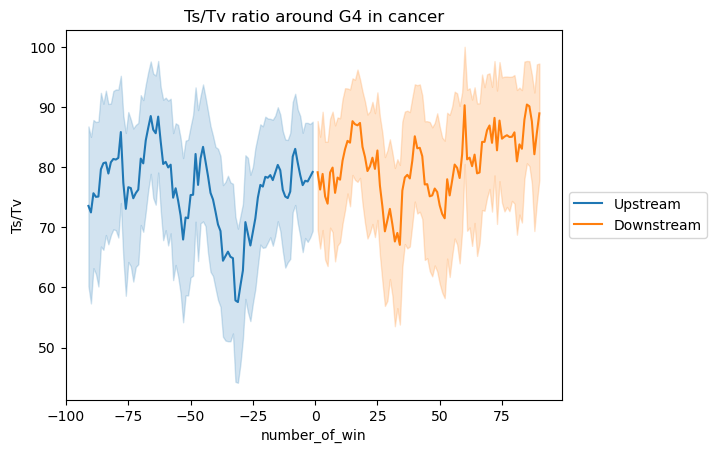

In [46]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer[df_win_cancer['side']=='up'], 
             x=-df_win_cancer['number_of_win'], y='Ts/Tv', label='Upstream')
sns.lineplot(data=df_win_cancer[(df_win_cancer['side']=='down') & (df_win_cancer['Ts/Tv'] > 0)], 
             x='number_of_win', y='Ts/Tv', label='Downstream')
axs.set(title='Ts/Tv ratio around G4 in cancer')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


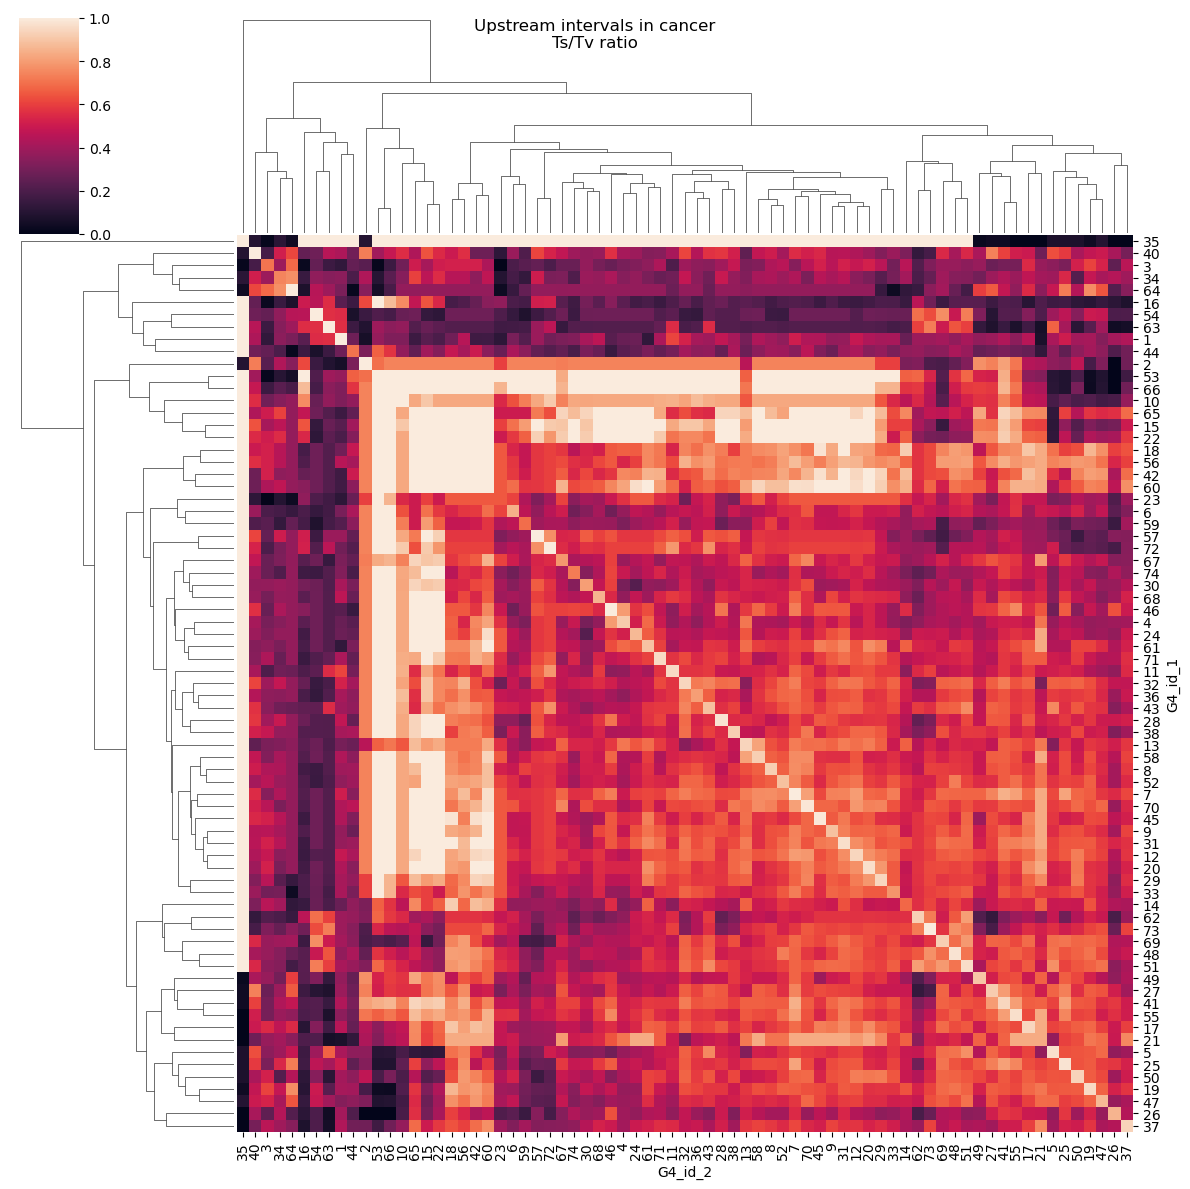

In [47]:
plot_intersecton(get_intersection_df(df_win_cancer, up_side=True, i_col='Ts/Tv'),
                title='Upstream intervals in cancer\nTs/Tv ratio')

C:\Users\777\AppData\Local\Temp\ipykernel_9624\1051803303.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(2*np.minimum(hist1, hist2) / (hist1 + hist2))/len(hist1 + hist2)


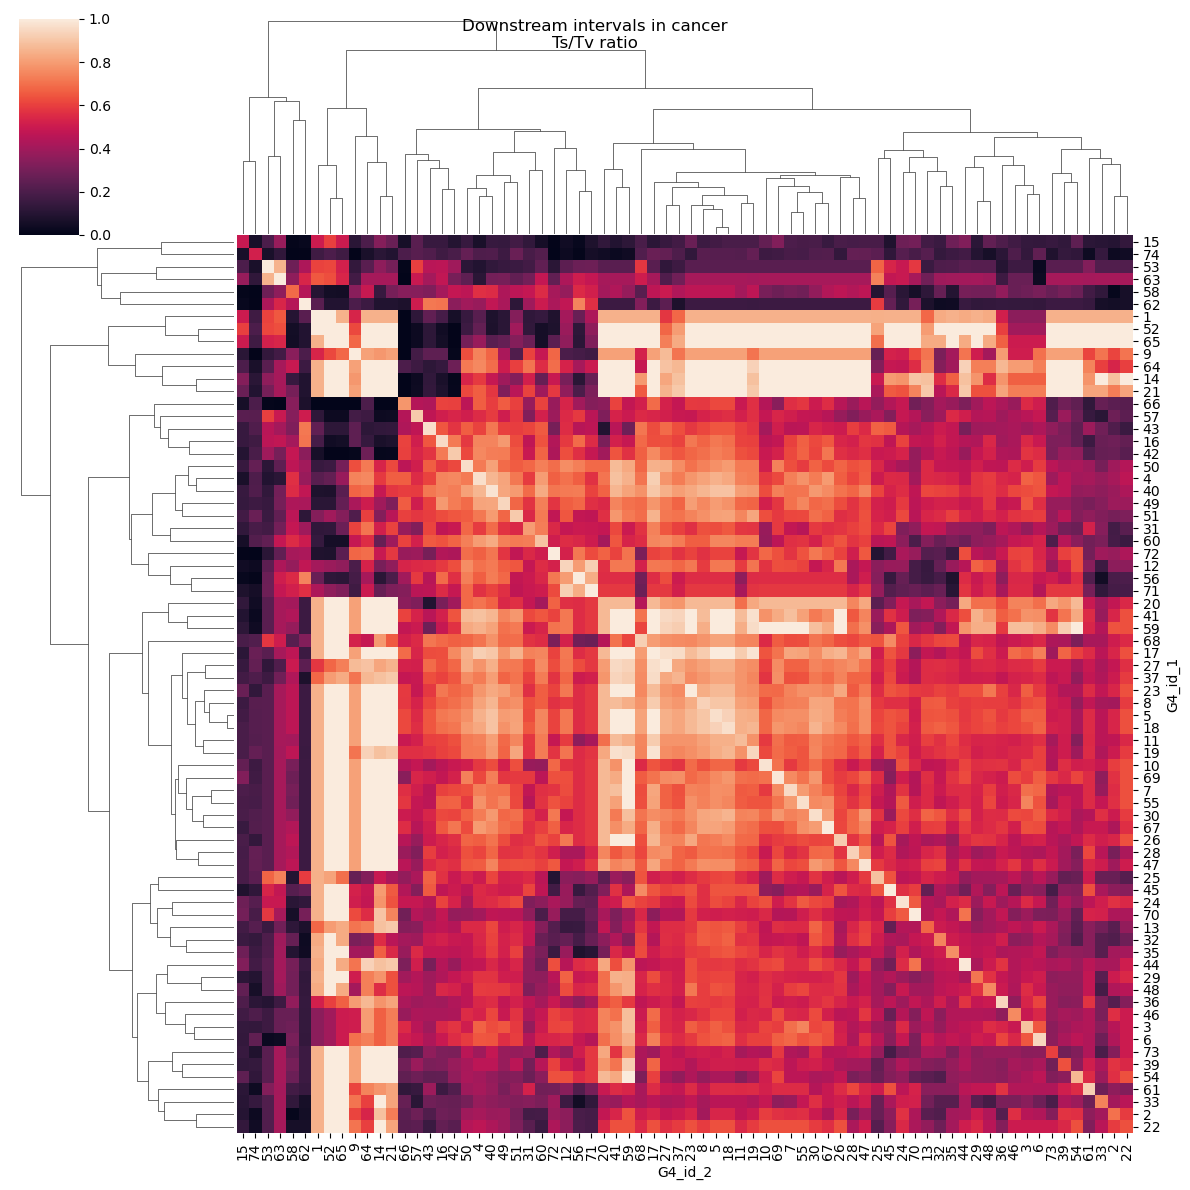

In [48]:
plot_intersecton(get_intersection_df(df_win_cancer, up_side=False, i_col='Ts/Tv'),
                title='Downstream intervals in cancer\nTs/Tv ratio')

In [49]:
og_up_tstv = [53, 66, 10, 65, 15, 22, 18, 56, 42, 60]
og_down_tstv = [1, 52, 65, 64, 14, 21]

In [50]:
df_win_cancer[(df_win_cancer['side'] == 'up') & (df_win_cancer['G4_id'].isin(og_up_tstv))]['Ts/Tv'].median()

100.0

In [51]:
df_win_cancer[(df_win_cancer['side'] == 'down') & (df_win_cancer['G4_id'].isin(og_down_tstv))]['Ts/Tv'].median()

100.0

## MutSpec

In [52]:
normMutG4_cancer = get_norm_mutspec(df_win_cancer)

In [53]:
normMutG4_cancer.insert(0, 'G4_id', df_win_cancer['G4_id'])
normMutG4_cancer.insert(1, 'side', df_win_cancer['side'])
normMutG4_cancer.insert(2, 'number_of_win', df_win_cancer['number_of_win'])
normMutG4_cancer = normMutG4_cancer.fillna(0)

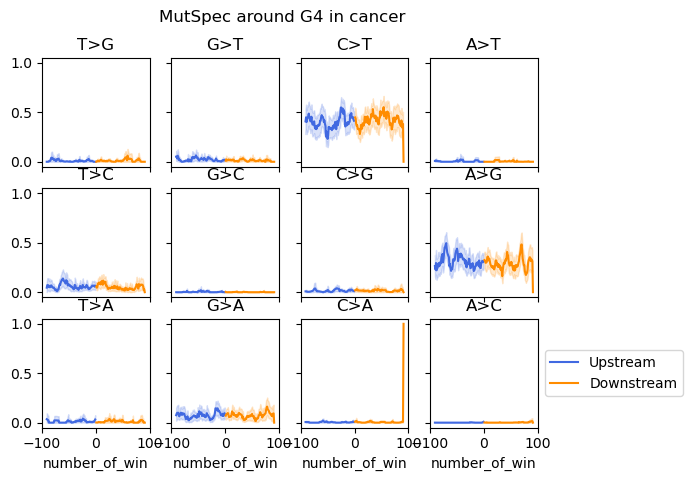

In [54]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
mutations = ['T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G', 'C>A', 'A>T', 'A>G', 'A>C']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 3
    row = i % 3
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='up'], 
                 x=-normMutG4_cancer['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('MutSpec around G4 in cancer')
plt.show()

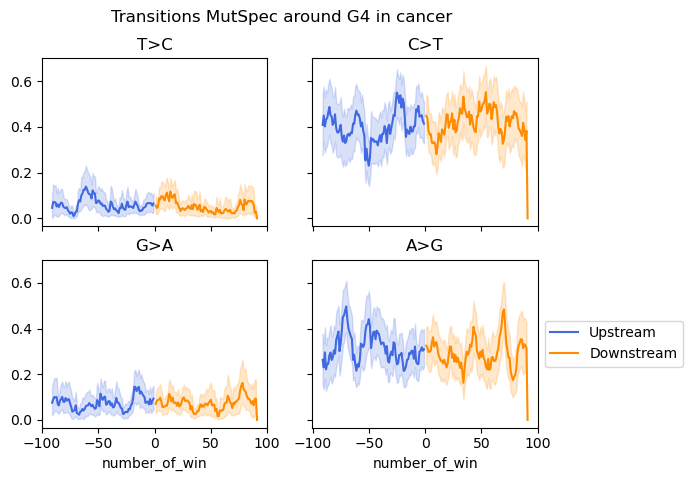

In [55]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='up'], 
                 x=-normMutG4_cancer['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around G4 in cancer')
plt.show()

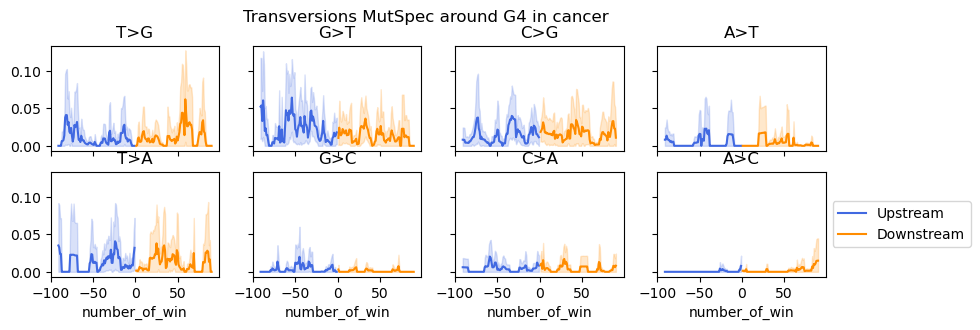

In [56]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=[10, 3])
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='up'], 
                 x=-normMutG4_cancer['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_cancer[(normMutG4_cancer['side']=='down') & (normMutG4_cancer['C>A'] < 1)], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transversions MutSpec around G4 in cancer', y=1)
plt.show()

## Strong G4

In [59]:
df_win_cancer_strong = df_win_cancer[df_win_cancer['G4_id'].isin(g4conf[g4conf['G4'] == 'G4']['G4_id'])]

In [60]:
normMutG4_cancer_strong = get_norm_mutspec(df_win_cancer_strong)

In [61]:
normMutG4_cancer_strong.insert(0, 'G4_id', df_win_cancer_strong['G4_id'])
normMutG4_cancer_strong.insert(1, 'side', df_win_cancer_strong['side'])
normMutG4_cancer_strong.insert(2, 'number_of_win', df_win_cancer_strong['number_of_win'])
normMutG4_cancer_strong = normMutG4_cancer_strong.fillna(0)

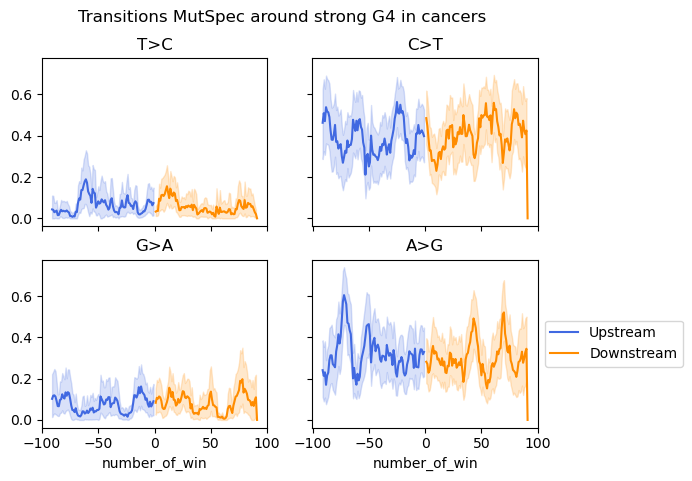

In [62]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_cancer_strong[normMutG4_cancer_strong['side']=='up'], 
                 x=-normMutG4_cancer_strong['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_cancer_strong[normMutG4_cancer_strong['side']=='down'], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around strong G4 in cancers')
plt.show()

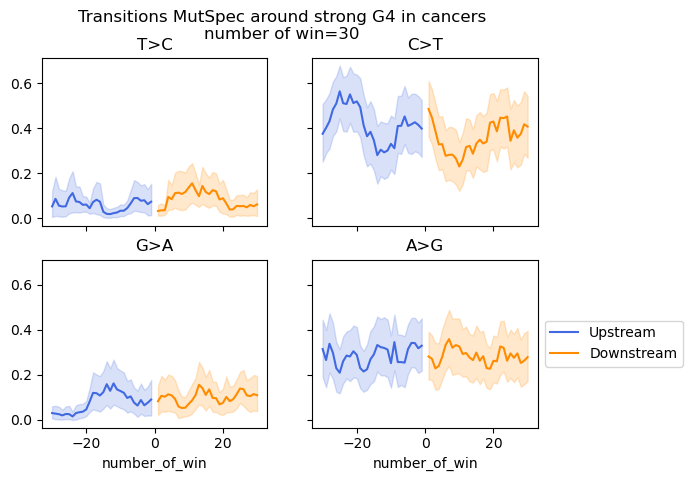

In [63]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']
number_of_win = range(31)

colors = ['royalblue', 'darkorange']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_cancer_strong[(normMutG4_cancer_strong['side']=='up') & 
                 (normMutG4_cancer_strong['number_of_win'].isin(number_of_win))], 
                 x=-normMutG4_cancer_strong['number_of_win'], y=mutation, ax=axs[row, col], color=colors[0])
    sns.lineplot(data=normMutG4_cancer_strong[(normMutG4_cancer_strong['side']=='down') &
                 (normMutG4_cancer_strong['number_of_win'].isin(number_of_win))], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[1]) \
        .set(title=mutation, ylabel='')
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Downstream']

# Add legend with custom handles and labels
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec around strong G4 in cancers\nnumber of win=30')
plt.show()

## Within G4

In [64]:
df_win_cancer_within = pd.read_csv('../data/processed/df_win_cancer_within.csv')

In [65]:
df_win_cancer_within

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within,1,285,294,CAAAAAATTT,6.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
1,1,within,2,286,295,AAAAAATTTC,6.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0
2,1,within,3,287,296,AAAAATTTCC,5.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0
3,1,within,4,288,297,AAAATTTCCA,5.0,2.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0
4,1,within,5,289,298,AAATTTCCAC,4.0,3.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,74,within,19,16545,16554,TCCCCTTAAA,3.0,4.0,0.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
2738,74,within,20,16546,16555,CCCCTTAAAT,3.0,4.0,0.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
2739,74,within,21,16547,16556,CCCTTAAATA,4.0,3.0,0.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0
2740,74,within,22,16548,16557,CCTTAAATAA,5.0,2.0,0.0,3.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0


[Text(0.5, 1.0, 'Number of mutation within G4 in cancer')]

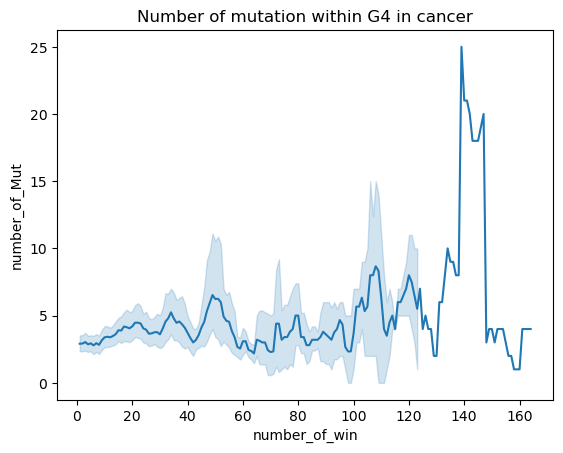

In [66]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer_within,
             x='number_of_win', y='number_of_Mut')

axs.set(title='Number of mutation within G4 in cancer')
# axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

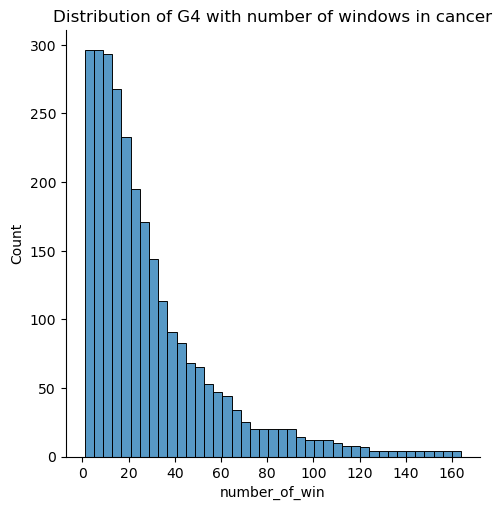

In [67]:
sns.displot(df_win_cancer_within['number_of_win']).set(title='Distribution of G4 with number of windows in cancer')

In [68]:
df_win_cancer_within.shape

(2742, 23)

In [69]:
df_win_cancer_within[df_win_cancer_within['number_of_win'] > 60]['G4_id'].count()

326

[Text(0.5, 1.0, 'Number of mutation within G4 in cancer')]

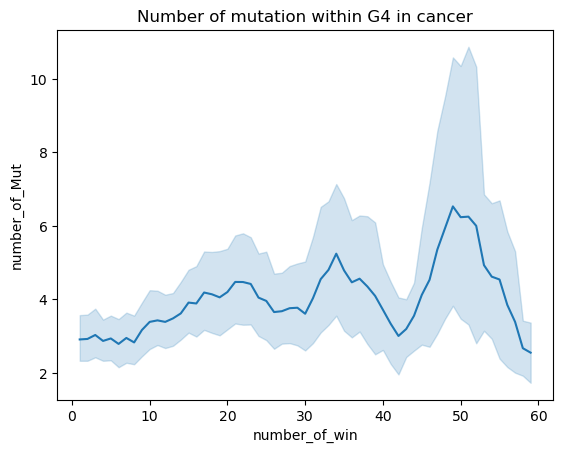

In [70]:
fig, axs = plt.subplots()
sns.lineplot(data=df_win_cancer_within[df_win_cancer_within['number_of_win'] < 60],
             x=df_win_cancer_within['number_of_win'], y='number_of_Mut')

axs.set(title='Number of mutation within G4 in cancer')
# axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [71]:
normMutG4_cancer_within = get_norm_mutspec(df_win_cancer_within)

In [72]:
normMutG4_cancer_within.insert(0, 'G4_id', df_win_cancer_within['G4_id'])
normMutG4_cancer_within.insert(1, 'side', df_win_cancer_within['side'])
normMutG4_cancer_within.insert(2, 'number_of_win', df_win_cancer_within['number_of_win'])
normMutG4_cancer_within = normMutG4_cancer_within.fillna(0)

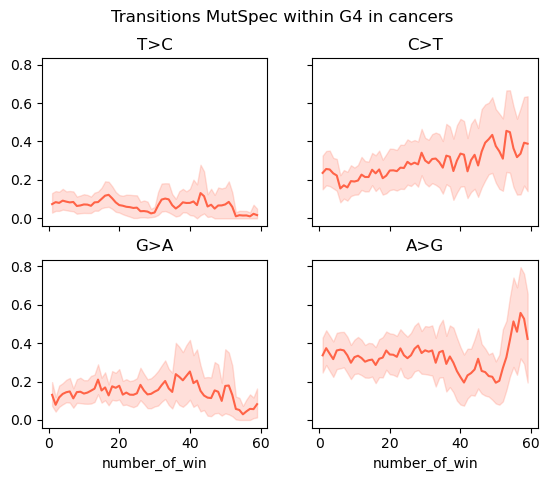

In [73]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    col = i // 2
    row = i % 2
    sns.lineplot(data=normMutG4_cancer_within[normMutG4_cancer_within['number_of_win'] < 60], 
                 x='number_of_win', y=mutation, ax=axs[row, col], color=colors[2])\
                .set(title=mutation, ylabel='')
        
# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Upstream', 'Downstream']

# # Add legend with custom handles and labels
# plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Transitions MutSpec within G4 in cancers')
plt.show()

## Inside and outside of G4

In [75]:
df_win_cancer = pd.read_csv('../data/processed/df_win_cancer.csv')

In [76]:
normMutG4_cancer = get_norm_mutspec(df_win_cancer)

In [77]:
normMutG4_cancer.insert(0, 'G4_id', df_win_cancer['G4_id'])
normMutG4_cancer.insert(1, 'side', df_win_cancer['side'])
normMutG4_cancer.insert(2, 'number_of_win', df_win_cancer['number_of_win'])
normMutG4_cancer = normMutG4_cancer.fillna(0)

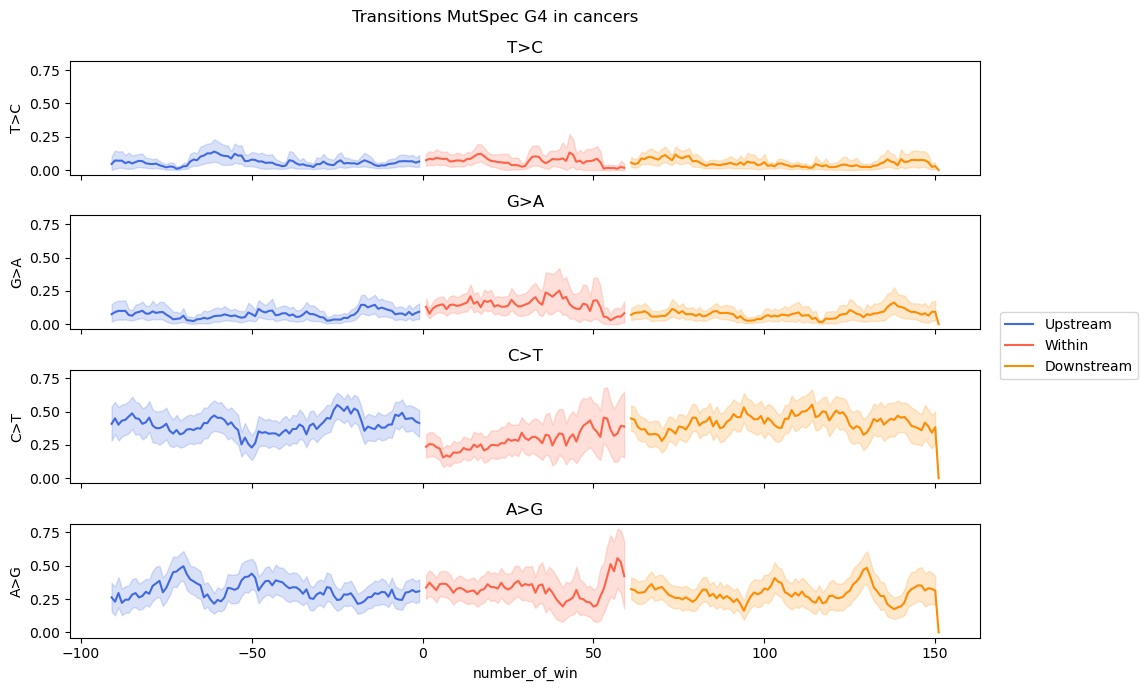

In [78]:
fig, axs = plt.subplots(4, sharex=True, sharey=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato']  # Specify colors for upstream and downstream plots

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='up'], 
                 x=-normMutG4_cancer['number_of_win'], y=mutation, ax=axs[row], color=colors[0])
    sns.lineplot(data=normMutG4_cancer_within[normMutG4_cancer_within['number_of_win'] < 60], 
                 x='number_of_win', y=mutation, ax=axs[row], color=colors[2])
    sns.lineplot(data=normMutG4_cancer[normMutG4_cancer['side']=='down'], 
                 x=normMutG4_cancer['number_of_win']+60, y=mutation, ax=axs[row], color=colors[1]) \
                .set_title(mutation)
        
# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[2]), plt.Line2D([], [], color=colors[1])]
labels = ['Upstream', 'Within' ,'Downstream']

# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.suptitle('Transitions MutSpec G4 in cancers')
plt.tight_layout()
plt.show()